In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [24]:
df = pd.read_csv('Mode_Craft_Ecommerce_Data - Online_Retail.csv')
df.index = pd.to_datetime(df.InvoiceDate)
df = df.dropna(how='all')

C:\Users\rajit\AppData\Local\Temp\ipykernel_1692\3474548107.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Mode_Craft_Ecommerce_Data - Online_Retail.csv')
C:\Users\rajit\AppData\Local\Temp\ipykernel_1692\3474548107.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.InvoiceDate)


In [26]:
def create_features(df):
    """
    Create time series features based on time series index.
    Revenue (Quantity x Unit Price)
    Day of Week

    Weekday or Weekend
    Quarter
    Product Name 
    """
    df = df.copy()
    df['revenue'] = df['Quantity'] * df['UnitPrice']
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['is_weekend'] = df.index.dayofweek >= 5
    df['InvoiceDate'] = df.index
    return df

df = create_features(df)

# fig, ax = plt.subplots(figsize=(10, 8))
# sns.boxplot(data=df, x='InvoiceDate', y='Revenue')
# ax.set_title('MW by Hour')
# plt.show()

<Axes: title={'center': 'Invoice vs Revenue'}, xlabel='InvoiceDate', ylabel='revenue'>

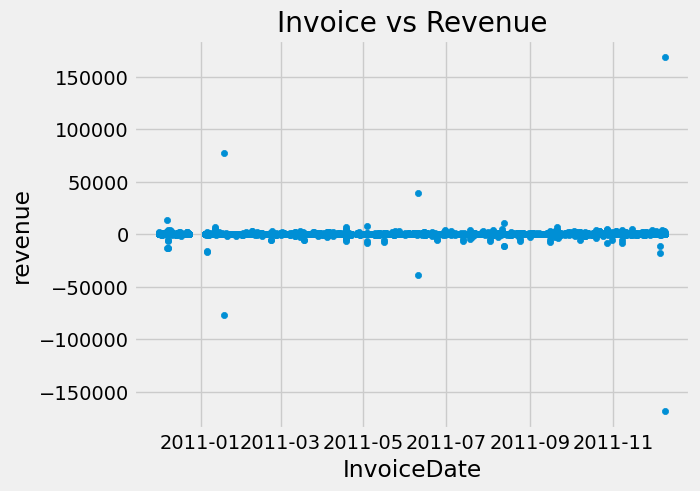

In [ ]:
df.sort_values(by='StockCode', ascending=True, inplace=True)
df.plot.scatter(x='StockCode', y='revenue',title='Invoice vs Revenue')
